In [1]:
# Import需要的套件
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from collections import OrderedDict
import pandas as pd
import numpy as np
import time
import cv2
import os

%run Dataset.ipynb
%run Model.ipynb

## Raed date

In [2]:
#分別將 training set、validation set、testing set 用 readfile 函式讀進來
data_dir = '../Data/food-11'
print("Reading data")

train_x, train_y = readfile(os.path.join(data_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))

val_x, val_y = readfile(os.path.join(data_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))

test_x = readfile(os.path.join(data_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


## Basic setting

In [3]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [4]:

model = Classifier().cuda()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params


12833803

In [5]:

model = Question2().cuda()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params


12983561

In [6]:

model = Question3().cuda()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params


12625035

In [7]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # optimizer 使用 Adam
num_epoch = 250

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        X = data[0].cuda()
        Y = data[1].cuda()
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        
        #### What's Wrong
        train_pred = model(X) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
            
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/tr`ain_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))

[001/250] 23.45 sec(s) Train Acc: 0.172309 Loss: 0.019005 | Val Acc: 0.190087 loss: 0.017544
[002/250] 23.02 sec(s) Train Acc: 0.226738 Loss: 0.017045 | Val Acc: 0.174052 loss: 0.017630
[003/250] 23.28 sec(s) Train Acc: 0.265660 Loss: 0.016318 | Val Acc: 0.265015 loss: 0.016257
[004/250] 23.17 sec(s) Train Acc: 0.290087 Loss: 0.015894 | Val Acc: 0.274927 loss: 0.015881
[005/250] 23.18 sec(s) Train Acc: 0.308534 Loss: 0.015505 | Val Acc: 0.259475 loss: 0.016237
[006/250] 23.16 sec(s) Train Acc: 0.323231 Loss: 0.015133 | Val Acc: 0.351020 loss: 0.014613
[007/250] 23.40 sec(s) Train Acc: 0.332962 Loss: 0.014921 | Val Acc: 0.343149 loss: 0.014887
[008/250] 23.46 sec(s) Train Acc: 0.353132 Loss: 0.014488 | Val Acc: 0.332362 loss: 0.014857
[009/250] 23.38 sec(s) Train Acc: 0.362153 Loss: 0.014352 | Val Acc: 0.389213 loss: 0.014049
[010/250] 23.55 sec(s) Train Acc: 0.376140 Loss: 0.013843 | Val Acc: 0.317493 loss: 0.015336
[011/250] 23.33 sec(s) Train Acc: 0.397831 Loss: 0.013665 | Val Acc: 0

[090/250] 24.21 sec(s) Train Acc: 0.794648 Loss: 0.004988 | Val Acc: 0.729155 loss: 0.006903
[091/250] 24.24 sec(s) Train Acc: 0.791810 Loss: 0.005035 | Val Acc: 0.734402 loss: 0.006609
[092/250] 24.13 sec(s) Train Acc: 0.801439 Loss: 0.004746 | Val Acc: 0.719242 loss: 0.007109
[093/250] 24.18 sec(s) Train Acc: 0.802047 Loss: 0.004689 | Val Acc: 0.716327 loss: 0.007049
[094/250] 24.14 sec(s) Train Acc: 0.803568 Loss: 0.004798 | Val Acc: 0.725364 loss: 0.006860
[095/250] 24.18 sec(s) Train Acc: 0.784006 Loss: 0.005237 | Val Acc: 0.739067 loss: 0.006732
[096/250] 24.18 sec(s) Train Acc: 0.803466 Loss: 0.004799 | Val Acc: 0.733236 loss: 0.006729
[097/250] 24.17 sec(s) Train Acc: 0.820495 Loss: 0.004460 | Val Acc: 0.730904 loss: 0.006689
[098/250] 24.59 sec(s) Train Acc: 0.789378 Loss: 0.005148 | Val Acc: 0.733819 loss: 0.006937
[099/250] 24.58 sec(s) Train Acc: 0.815224 Loss: 0.004437 | Val Acc: 0.727405 loss: 0.006899
[100/250] 24.84 sec(s) Train Acc: 0.816440 Loss: 0.004398 | Val Acc: 0

[179/250] 23.63 sec(s) Train Acc: 0.925096 Loss: 0.001889 | Val Acc: 0.749563 loss: 0.007679
[180/250] 23.11 sec(s) Train Acc: 0.936550 Loss: 0.001722 | Val Acc: 0.757434 loss: 0.006996
[181/250] 23.54 sec(s) Train Acc: 0.935029 Loss: 0.001832 | Val Acc: 0.758309 loss: 0.007009
[182/250] 23.39 sec(s) Train Acc: 0.924488 Loss: 0.002015 | Val Acc: 0.766764 loss: 0.006936
[183/250] 24.82 sec(s) Train Acc: 0.936347 Loss: 0.001608 | Val Acc: 0.767055 loss: 0.007020
[184/250] 24.20 sec(s) Train Acc: 0.929353 Loss: 0.001814 | Val Acc: 0.767055 loss: 0.006718
[185/250] 24.27 sec(s) Train Acc: 0.920332 Loss: 0.002057 | Val Acc: 0.743440 loss: 0.007848
[186/250] 24.28 sec(s) Train Acc: 0.920941 Loss: 0.002095 | Val Acc: 0.762099 loss: 0.006779
[187/250] 23.84 sec(s) Train Acc: 0.937462 Loss: 0.001524 | Val Acc: 0.763848 loss: 0.006756
[188/250] 23.79 sec(s) Train Acc: 0.933509 Loss: 0.001816 | Val Acc: 0.768513 loss: 0.006842
[189/250] 23.87 sec(s) Train Acc: 0.930266 Loss: 0.001871 | Val Acc: 0

In [36]:
## Confusion matrix
from sklearn.metrics import confusion_matrix

val_set = ImgDataset(val_x, val_y, test_transform)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

model.eval()

predlist = torch.zeros(0,dtype=torch.long, device='cpu')
truelist = torch.zeros(0,dtype=torch.long, device='cpu')

for i, data in enumerate(val_loader):
    val_pred = model(data[0].cuda())
    val_pred = torch.tensor(val_pred, dtype=torch.long, device='cpu')
    
    
    idx = 0
    max_ = -1000000
    for i in range(11):
        if val_pred[0][i] > max_:
            max_ = val_pred[0][i]
            idx = i
            
    idx = torch.tensor([idx], dtype=torch.long, device='cpu')
    
    predlist = torch.cat([predlist, idx.cpu()])
    truelist = torch.cat([truelist, data[1].cpu()])
#     predlist = torch.cat([predlist, val_pred.view(-1).cpu()])
#     truelist = torch.cat([truelist, data[1].view(-1).cpu()])

conf_mat=confusion_matrix(truelist.numpy(), predlist.numpy())
print(conf_mat)

/home/mj/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[[265   1  24  20  12  25   0   1   6   8   0]
 [ 15  62  39   1   7   1   0   6   5   8   0]
 [ 32  21 340   5  19  20   0   0  30  27   6]
 [ 55   5  15 225   3   7   0   0   6   5   6]
 [ 36   3  12   0 246  21   0   1   4   3   0]
 [ 26   4  21   4  17 355   0   1  11   8   2]
 [  6   0   6   5   3   0 116   3   1   5   2]
 [ 11   0   4   1   2   0   2  75   0   1   0]
 [ 11   0  13   6   6  28   0   0 276   5   2]
 [  6   4  15   4   3   4   1   5  11 447   0]
 [  2   3   3   0   7   3   0   1   4   0 209]]


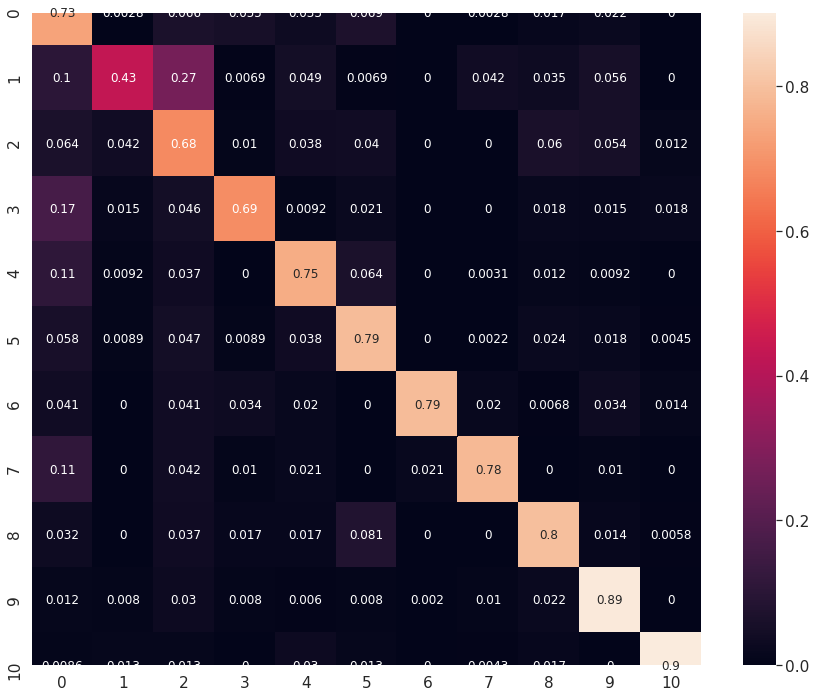

In [82]:
import seaborn as sn
import matplotlib.pyplot as plt

norm_cm = normalize(conf_mat, norm='l1', axis=1)

df_cm = pd.DataFrame(norm_cm, index = [i for i in range(11)],
                  columns = [i for i in range(11)])
plt.figure(figsize = (15,12))

sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True,  annot_kws={"size": 12})
plt.savefig('../CM.png')
plt.show()

In [80]:
from sklearn.preprocessing import normalize

A = [[1,2,3], [4,5,6]]
normalize(A, norm='l1', axis=1)

array([[0.16666667, 0.33333333, 0.5       ],
       [0.26666667, 0.33333333, 0.4       ]])

In [38]:
torch.save(model.state_dict(), '../Model/test.pth')

In [4]:
train_val_x = np.concatenate((train_x, val_x), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [6]:
model_best = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.SGD(model_best.parameters(), lr=0.01, momentum=0.9) # optimizer 使用 Adam
num_epoch = 250

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

        #將結果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))

[001/250] 27.16 sec(s) Train Acc: 0.218261 Loss: 0.016981
[002/250] 26.88 sec(s) Train Acc: 0.306934 Loss: 0.015299
[003/250] 26.87 sec(s) Train Acc: 0.333258 Loss: 0.014686
[004/250] 26.88 sec(s) Train Acc: 0.364245 Loss: 0.014057
[005/250] 26.91 sec(s) Train Acc: 0.392674 Loss: 0.013576
[006/250] 26.89 sec(s) Train Acc: 0.407942 Loss: 0.013247
[007/250] 26.87 sec(s) Train Acc: 0.428851 Loss: 0.012838
[008/250] 26.92 sec(s) Train Acc: 0.438403 Loss: 0.012489
[009/250] 26.92 sec(s) Train Acc: 0.460063 Loss: 0.012154
[010/250] 26.90 sec(s) Train Acc: 0.477888 Loss: 0.011806
[011/250] 26.84 sec(s) Train Acc: 0.495187 Loss: 0.011555
[012/250] 26.87 sec(s) Train Acc: 0.502708 Loss: 0.011269
[013/250] 26.92 sec(s) Train Acc: 0.510003 Loss: 0.011177
[014/250] 27.33 sec(s) Train Acc: 0.528054 Loss: 0.010770
[015/250] 27.17 sec(s) Train Acc: 0.529332 Loss: 0.010645
[016/250] 26.88 sec(s) Train Acc: 0.538809 Loss: 0.010488
[017/250] 27.30 sec(s) Train Acc: 0.552497 Loss: 0.010189
[018/250] 27.2

[143/250] 27.56 sec(s) Train Acc: 0.899819 Loss: 0.002279
[144/250] 27.03 sec(s) Train Acc: 0.906438 Loss: 0.002198
[145/250] 26.84 sec(s) Train Acc: 0.905460 Loss: 0.002147
[146/250] 26.85 sec(s) Train Acc: 0.905235 Loss: 0.002158
[147/250] 26.84 sec(s) Train Acc: 0.908619 Loss: 0.002074
[148/250] 26.86 sec(s) Train Acc: 0.911327 Loss: 0.001981
[149/250] 26.83 sec(s) Train Acc: 0.912530 Loss: 0.002079
[150/250] 26.83 sec(s) Train Acc: 0.908619 Loss: 0.002039
[151/250] 26.85 sec(s) Train Acc: 0.908318 Loss: 0.002055
[152/250] 26.87 sec(s) Train Acc: 0.914486 Loss: 0.001972
[153/250] 26.85 sec(s) Train Acc: 0.913357 Loss: 0.001999
[154/250] 26.84 sec(s) Train Acc: 0.909672 Loss: 0.002103
[155/250] 26.90 sec(s) Train Acc: 0.913733 Loss: 0.001972
[156/250] 26.88 sec(s) Train Acc: 0.911853 Loss: 0.002015
[157/250] 26.91 sec(s) Train Acc: 0.918697 Loss: 0.001865
[158/250] 27.11 sec(s) Train Acc: 0.921179 Loss: 0.001751
[159/250] 26.90 sec(s) Train Acc: 0.918773 Loss: 0.001900
[160/250] 26.9

In [7]:
torch.save(model_best.state_dict(), '../Model/best_sgdm_250.pth')

In [8]:
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [9]:
model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_best(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

In [10]:
#將結果寫入 csv 檔
with open("../Output/predict_sgdm.csv", 'w') as f:
    f.write('Id,Category\n')
    for i, y in  enumerate(prediction):
        f.write('{},{}\n'.format(i, y))